# 1. Import

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import gc

import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)

In [92]:
demo = pd.read_csv('LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv') # 고객 정보
pdde = pd.read_csv('LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv') # 유통사 상품 구매 내역
cop_u = pd.read_csv('LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv') # 제휴사 이용 정보
pd_clac = pd.read_csv('LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv') # 상품 분류 정보
br = pd.read_csv('LPOINT_BIG_COMP/LPOINT_BIG_COMP_05_BR.csv') # 점포 정보
lpay = pd.read_csv('LPOINT_BIG_COMP/LPOINT_BIG_COMP_06_LPAY.csv') # 엘페이 이용

C:\Users\jinho\AppData\Local\Temp/ipykernel_16892/3662843832.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pdde = pd.read_csv('LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv') # 유통사 상품 구매 내역


# 2. Data preprosessing

### 결측치 처리

In [93]:
cop_u['br_c'] = cop_u.br_c.fillna('기타')
pdde['br_c'] = pdde.br_c.fillna('기타')

### datetime64

In [94]:
pdde['de_dt'] = pdde.de_dt.astype(str).astype('datetime64')
cop_u['de_dt'] = cop_u.de_dt.astype(str).astype('datetime64')
lpay['de_dt'] = lpay.de_dt.astype(str).astype('datetime64')

### 중복값 제거

In [95]:
pdde = pdde.drop_duplicates().reset_index().iloc[:,1:]

### 이상치 제거

In [96]:
# pdde & pd_c merge
pdde = pdde.merge(pd_clac,on = 'pd_c',how = 'left')

In [97]:
pdde_pd = pdde.pd_nm.unique()

In [98]:
# 정규화
def z_score_normalize1(series,k):
    lst = series.values
    idx = series.index
    normalized = []
    idx_lst = []
    m = np.median(lst)
    s = np.std(lst)
    if s == 0 :
        pass
    else:
        for value ,idx_ in zip(lst,idx):
            normalized_num = (value - m) / s
            if normalized_num >=k:
                normalized.append(normalized_num)
                idx_lst.append(idx_)
    return normalized,idx_lst

In [99]:
# pdde
ex_idx = []
for i in pdde_pd:
    ex_idx.extend(z_score_normalize1(pdde.query('pd_nm == @i')['buy_am'],3)[1])

In [100]:
# pdde 이상치 데이터
pdde_extra = pdde.loc[ex_idx,:].copy().reset_index().iloc[:,1:]

In [101]:
pdde_extra.shape

(63703, 13)

In [102]:
pdde = pdde.drop(ex_idx).reset_index().iloc[:,1:]

In [103]:
pdde.loc[np.argmax(pdde.buy_am),:]

cust                     M019905252
rct_no                 A01495808280
chnl_dv                           1
cop_c                           A01
br_c                        A010001
pd_c                         PD1752
de_dt           2021-12-26 00:00:00
de_hr                            16
buy_am                   21492800.0
buy_ct                            1
pd_nm                          남성시계
clac_hlv_nm                    패션잡화
clac_mcls_nm                     시계
Name: 641143, dtype: object

In [104]:
# cop_u
cop_c_nm = cop_u.cop_c.unique()

ex_idx_cop = []
for i in cop_c_nm:
    ex_idx_cop.extend(z_score_normalize1(cop_u.query('cop_c == @i')['buy_am'],2.5)[1])

In [105]:
cop_u_extra = cop_u.loc[ex_idx_cop,:].copy()

In [106]:
cop_u = cop_u.drop(ex_idx_cop).reset_index().iloc[:,1:]

### pdde, cop_u 거래데이터가 없는 고객 제거

In [107]:
demo_cust = set(demo.cust.unique())
cop_u_cust = set(cop_u.cust.unique())
pdde_cust = set(pdde.cust.unique())

In [108]:
cop_u_x = demo_cust - cop_u_cust - pdde_cust

In [109]:
idx = list(cop_u_x)

In [110]:
demo = demo.query('cust != @idx').reset_index().iloc[:,1:]

# 3. Feature Engineering for Persona

## 0) pdde, cop_u, lpay 사용 여부

In [111]:
tot_lpay_idx = list(lpay.cust.unique())

In [112]:
asd = demo.query('cust not in @tot_lpay_idx').cust.unique()

In [113]:
not_cust = []
pdde_cust = pdde.cust.unique()
for i in asd:
    if i not in pdde_cust: 
        not_cust.append(i)

notnot_cust = []
cop_u_cust = cop_u.cust.unique()
for i in not_cust:
    if i not in cop_u_cust:
        notnot_cust.append(i)

In [114]:
len(notnot_cust) ## 삭제해야 할 고객 데이터

0

In [115]:
pdde_l = pdde.query('cust in @tot_lpay_idx')

In [116]:
lpay_pdde_cust = pdde_l.cust.unique()

In [117]:
not_cop_cust = []
cop_u_cust = cop_u.cust.unique()
for i in lpay_pdde_cust:
    if i not in cop_u_cust: 
        not_cop_cust.append(i)

In [118]:
len(not_cop_cust)

697

In [119]:
cop_u_lpay = cop_u.query('cust in @tot_lpay_idx').cust.unique()

In [120]:
not_pdde_cust = []
pdde_cust = pdde.cust.unique()
for i in cop_u_lpay:
    if i not in pdde_cust: 
        not_pdde_cust.append(i)

In [121]:
len(not_pdde_cust) ## 212명

216

In [122]:
both_cust = []
for i in tot_lpay_idx:
    if i not in not_pdde_cust and  i not in not_cop_cust:
        both_cust.append(i)

In [123]:
demo['lpay_pdde_only'] = demo['cust'].apply(lambda x : 1 if x in not_cop_cust else 0 )
demo['lpay_cop_only'] =  demo['cust'].apply(lambda x : 1 if x in not_pdde_cust else 0 )
demo['lpay_both'] =  demo['cust'].apply(lambda x : 1 if x in both_cust else 0 )

___

## 1) 소비 적극성 = 구매 주기

In [124]:
# 구매주기
a = pdde.groupby('cust')['de_dt'].agg([('pdde_구매주기', lambda x : int(((x.max()-x.min()).days)/x.nunique()))])
b = cop_u.groupby('cust')['de_dt'].agg([('cop_u_구매주기', lambda x : int(((x.max()-x.min()).days)/x.nunique()))])

In [125]:
구매주기 = pd.merge(a, b, on = 'cust', how = 'outer')
구매주기 = 구매주기.fillna(0)
구매주기 = 구매주기.astype(int)
구매주기

,pdde_구매주기,cop_u_구매주기
cust,,
M000034966,48,0
M000136117,12,19
M000201112,31,0
M000225114,8,42
M000261625,15,0
...,...,...
M998572907,0,0
M999428656,0,18
M999493501,0,30


In [126]:
print('# pdde_구매주기 #  _1사분위_ :', a.describe().iloc[4,0], '  _2사분위_ :', a.describe().iloc[5,0], '  _3사분위_ :', a.describe().iloc[6,0])
print('# cop_u_구매주기 # _1사분위_ :', b.describe().iloc[4,0], ' _2사분위_ :', b.describe().iloc[5,0], '  _3사분위_ :', b.describe().iloc[6,0])

# pdde_구매주기 #  _1사분위_ : 5.0   _2사분위_ : 11.0   _3사분위_ : 20.0
# cop_u_구매주기 # _1사분위_ : 11.0  _2사분위_ : 22.0   _3사분위_ : 34.0


In [127]:
def pdde_소비적극성(x):
    if x == 0:
        x = 1
    elif 0< x <= 5:
        x = 5 - (x/5)
    elif 5<x<=11:
        x = 4 - (x/11)
    elif 11<x<=20:
        x = 3 - (x/20)
    elif x > 20:
        x = 2- (x/182)
    return round(x, 2)

def cop_u_소비적극성(x):
    if x == 0:
        x = 1
    elif 0< x <= 11:
        x = 5 - (x/11)
    elif 11<x<=22:
        x = 4 - (x/22)
    elif 22<x<=34:
        x = 3 - (x/34)
    elif x > 34:
        x = 2- (x/176)
    return round(x, 2)

In [128]:
# 구매주기 -> 소비적극성
a = a.pdde_구매주기.apply(lambda x : pdde_소비적극성(x)).reset_index().rename(columns = {'pdde_구매주기' : 'pdde_소비적극성'})
b = b.cop_u_구매주기.apply(lambda x : cop_u_소비적극성(x)).reset_index().rename(columns = {'cop_u_구매주기' : 'cop_u_소비적극성'})

In [129]:
demo = pd.merge(demo, a, on = 'cust', how = 'outer')
demo = pd.merge(demo, b, on = 'cust', how = 'outer')

demo = demo.fillna(0)
demo.isna().sum()

cust              0
ma_fem_dv         0
ages              0
zon_hlv           0
lpay_pdde_only    0
lpay_cop_only     0
lpay_both         0
pdde_소비적극성        0
cop_u_소비적극성       0
dtype: int64

In [131]:
demo[['cust','pdde_소비적극성','cop_u_소비적극성']]

,cust,pdde_소비적극성,cop_u_소비적극성
0,M000034966,1.74,1.00
1,M000136117,2.40,3.14
2,M000201112,1.83,0.00
3,M000225114,3.27,1.76
4,M000261625,2.25,1.00
...,...,...,...
29696,M999708287,0.00,1.00
29697,M999770689,4.40,2.18
29698,M999849895,2.25,1.00
29699,M999926092,0.00,1.74


___

## 2) 소비 충동성 = 논문 근거

__충동구매 소비자의 구매행위와 심리적 특성에 관한 연구__  
https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO199611919394002&oCn=JAKO199611919394002&dbt=JAKO&journal=NJOU00290513

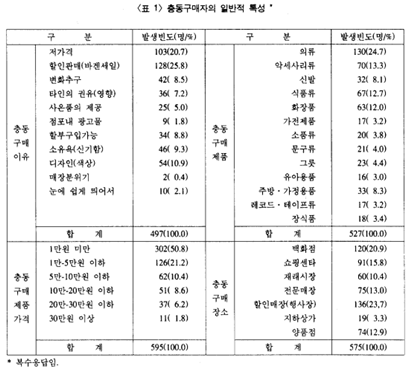

< 품목에 대한 충동성 >  
의류 : 5  
식품 : 4  
화장품 : 3  
가정 : 2  
그외 : 1  

< 제품가격에 의한 충동성 >  
1만원 미만 : 5  
1만 ~ 5만원 이하 : 4  
5만 ~ 10만원 이하 : 3  
10만 ~ 20만 이하 : 2  
20만원 이상 : 1

In [133]:
의류 = list(pd_clac[pd_clac['clac_hlv_nm'].str.contains("패션|의류|속옷")].pd_c.values)
식품 = list(pd_clac[pd_clac['clac_hlv_nm'].str.contains("축산물|수산물|채소|과일|조미료|조리식품|과자|건강식품|냉장식품|건해산물|음료|주류|커피/차|병통조림|유제품|유아식품")].pd_c.values)
화장품 = list(pd_clac[pd_clac['clac_hlv_nm'].str.contains("화장품/뷰티케어|퍼스널케어")].pd_c.values)
가정 = list(pd_clac[pd_clac['clac_hlv_nm'].str.contains("생활/주방가전|조리식품|식기/조리기구|침구/수예|주방잡화|가구|청소/세탁/욕실용품|세제/위생|인테리어/조명")].pd_c.values)
그외 = 의류 + 식품 + 화장품 + 가정

In [134]:
의류_충동성_5 = pdde.query('pd_c == @의류 & buy_am < 10000').index.to_list()
의류_충동성_4 = pdde.query('pd_c == @의류 & 10000 <= buy_am < 50000').index.to_list()
의류_충동성_3 = pdde.query('pd_c == @의류 & 50000 <= buy_am < 100000').index.to_list()
의류_충동성_2 = pdde.query('pd_c == @의류 & 100000 <= buy_am < 200000').index.to_list()
의류_충동성_1 = pdde.query('pd_c == @의류 &  buy_am >= 200000').index.to_list()

식품_충동성_5 = pdde.query('pd_c == @식품 & buy_am < 10000').index.to_list()
식품_충동성_4 = pdde.query('pd_c == @식품 & 10000 <= buy_am < 50000').index.to_list()
식품_충동성_3 = pdde.query('pd_c == @식품 & 50000 <= buy_am < 100000').index.to_list()
식품_충동성_2 = pdde.query('pd_c == @식품 & 100000 <= buy_am < 200000').index.to_list()
식품_충동성_1 = pdde.query('pd_c == @식품 &  buy_am >= 200000').index.to_list()

화장품_충동성_5 = pdde.query('pd_c == @화장품 & buy_am < 10000').index.to_list()
화장품_충동성_4 = pdde.query('pd_c == @화장품 & 10000 <= buy_am < 50000').index.to_list()
화장품_충동성_3 = pdde.query('pd_c == @화장품 & 50000 <= buy_am < 100000').index.to_list()
화장품_충동성_2 = pdde.query('pd_c == @화장품 & 100000 <= buy_am < 200000').index.to_list()
화장품_충동성_1 = pdde.query('pd_c == @화장품 &  buy_am >= 200000').index.to_list()

가정_충동성_5 = pdde.query('pd_c == @가정 & buy_am < 10000').index.to_list()
가정_충동성_4 = pdde.query('pd_c == @가정 & 10000 <= buy_am < 50000').index.to_list()
가정_충동성_3 = pdde.query('pd_c == @가정 & 50000 <= buy_am < 100000').index.to_list()
가정_충동성_2 = pdde.query('pd_c == @가정 & 100000 <= buy_am < 200000').index.to_list()
가정_충동성_1 = pdde.query('pd_c == @가정 &  buy_am >= 200000').index.to_list()

그외_충동성_5 = pdde.query('pd_c != @그외 & buy_am < 10000').index.to_list()
그외_충동성_4 = pdde.query('pd_c != @그외 & 10000 <= buy_am < 50000').index.to_list()
그외_충동성_3 = pdde.query('pd_c != @그외 & 50000 <= buy_am < 100000').index.to_list()
그외_충동성_2 = pdde.query('pd_c != @그외 & 100000 <= buy_am < 200000').index.to_list()
그외_충동성_1 = pdde.query('pd_c != @그외 &  buy_am >= 200000').index.to_list()

In [135]:
품목_충동성 = pdde.pd_c.apply(lambda x : 5 if x in 의류 else 4 if x in 식품 else 3 if x in 화장품 else 2 if x in 가정 else 1).reset_index()
품목_충동성 = 품목_충동성.rename(columns = {'pd_c' : '품목_충동성'}).iloc[:,1]

pdde = pd.concat([pdde, 품목_충동성], axis = 1)
pdde.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,품목_충동성
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,5
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1,기타주방일회용품,주방잡화,주방일회용품,2
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,5
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,5
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,9900.0,1,커피/음료,테넌트/음식점,식당,1


In [137]:
pdde['세부_충동성'] = pdde.pd_c

pdde.loc[의류_충동성_5, '세부_충동성'] = 5
pdde.loc[의류_충동성_4, '세부_충동성'] = 4
pdde.loc[의류_충동성_3, '세부_충동성'] = 3
pdde.loc[의류_충동성_2, '세부_충동성'] = 2
pdde.loc[의류_충동성_1, '세부_충동성'] = 1

pdde.loc[식품_충동성_5, '세부_충동성'] = 5
pdde.loc[식품_충동성_4, '세부_충동성'] = 4
pdde.loc[식품_충동성_3, '세부_충동성'] = 3
pdde.loc[식품_충동성_2, '세부_충동성'] = 2
pdde.loc[식품_충동성_1, '세부_충동성'] = 1

pdde.loc[화장품_충동성_5, '세부_충동성'] = 5
pdde.loc[화장품_충동성_4, '세부_충동성'] = 4
pdde.loc[화장품_충동성_3, '세부_충동성'] = 3
pdde.loc[화장품_충동성_2, '세부_충동성'] = 2
pdde.loc[화장품_충동성_1, '세부_충동성'] = 1

pdde.loc[가정_충동성_5, '세부_충동성'] = 5
pdde.loc[가정_충동성_4, '세부_충동성'] = 4
pdde.loc[가정_충동성_3, '세부_충동성'] = 3
pdde.loc[가정_충동성_2, '세부_충동성'] = 2
pdde.loc[가정_충동성_1, '세부_충동성'] = 1

pdde.loc[그외_충동성_5, '세부_충동성'] = 5
pdde.loc[그외_충동성_4, '세부_충동성'] = 4
pdde.loc[그외_충동성_3, '세부_충동성'] = 3
pdde.loc[그외_충동성_2, '세부_충동성'] = 2
pdde.loc[그외_충동성_1, '세부_충동성'] = 1

pdde.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,품목_충동성,세부_충동성
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,5,4
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1,기타주방일회용품,주방잡화,주방일회용품,2,3
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,5,4
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,5,4
4,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,9900.0,1,커피/음료,테넌트/음식점,식당,1,5


In [139]:
pdde['buy_am'] = pdde.buy_am.astype(int)

In [141]:
pdde[['buy_am','세부_충동성']]

,buy_am,세부_충동성
0,15000,4
1,79700,3
2,19000,4
3,19000,4
4,9900,5
...,...,...
4080681,50000,3
4080682,10000,4
4080683,289000,1
4080684,200000,1


In [142]:
gc.collect()

8

In [143]:
pdde['소비충동성'] = pdde[['품목_충동성', '세부_충동성']].sum(axis = 1)/(2) # 최대값을 5로 맞1추기 위함(소비적극성)

In [144]:
소비충동성 = round(pdde.groupby('cust')['소비충동성'].mean(),2)

In [145]:
demo = pd.merge(demo, 소비충동성, on = 'cust', how = 'outer')

In [146]:
demo = demo.fillna(0)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,lpay_pdde_only,lpay_cop_only,lpay_both,pdde_소비적극성,cop_u_소비적극성,소비충동성
0,M000034966,여성,40대,Z07,0,0,0,1.74,1.00,4.22
1,M000136117,여성,30대,Z11,0,0,1,2.40,3.14,3.29
2,M000201112,여성,50대,Z17,0,0,0,1.83,0.00,4.05
3,M000225114,여성,40대,Z17,0,0,0,3.27,1.76,4.22
4,M000261625,여성,40대,Z17,0,0,0,2.25,1.00,2.98


___

## 3) 가격 민감도

In [171]:
# 제품 1개 가격
pdde['buy_one'] = pdde['buy_am']/pdde['buy_ct']

In [172]:
pdde_mean = pdde.groupby('clac_mcls_nm')['buy_one'].mean() # 제품 평균 가격

In [154]:
br_mean = []
for i in range(pdde.shape[0]):
    br_nm = pdde.loc[i,'clac_mcls_nm'] # 제품명
    value = pdde_mean[br_nm] # 해당제품 전체 평균 가격
    if pdde.loc[i,'buy_one'] < value: # 해당제품 전체 평균 가격보다 item의 가격이 작으면 가격에 민감하다고 판단
        br_mean.append(1)
    else:
        br_mean.append(0)
pdde['가격민감성'] = br_mean

#pdde['clac_mcls_nm'].apply(lambda x  :  1 if x - pdde_mean[x] <0 else 0 )

In [183]:
a = pdde.groupby('cust')['가격민감성'].sum().reset_index()
민감성_cust = a.cust

In [187]:
a

,cust,가격민감성
0,M000034966,27
1,M000136117,39
2,M000201112,19
3,M000225114,89
4,M000261625,28
...,...,...
26845,M999599111,13
26846,M999673157,9
26847,M999770689,274
26848,M999849895,40


In [188]:
print('# pdde_가격민감도 #  _1사분위_ :', a.describe().iloc[4,0], '  _2사분위_ :', a.describe().iloc[5,0], '  _3사분위_ :', a.describe().iloc[6,0])

# pdde_가격민감도 #  _1사분위_ : 17.0   _2사분위_ : 52.0   _3사분위_ : 126.0


In [189]:
a.describe()

,가격민감성
count,26850.000000
mean,97.062756
std,145.353972
min,0.000000
25%,17.000000
50%,52.000000
75%,126.000000
max,9487.000000


In [190]:
def pdde_가격민감성(x):
    if x >= 126:
        x = 5 - (x/9487)
    elif 52<=x<126:
        x = 4 - (x/126)
    elif 17<=x<52:
        x = 3 - (x/52)
    elif x<17:
        x = 2 -(x/17)
    return round(x, 2)

In [191]:
a = a.가격민감성.apply(lambda x : pdde_가격민감성(x))
a = pd.concat([민감성_cust, a], axis = 1)

In [193]:
demo = pd.merge(demo, a, on = 'cust', how = 'outer').fillna(0)

In [196]:
demo[['cust','가격민감성']]

,cust,가격민감성
0,M000034966,2.48
1,M000136117,2.25
2,M000201112,2.63
3,M000225114,3.29
4,M000261625,2.46
...,...,...
29696,M999708287,0.00
29697,M999770689,4.97
29698,M999849895,2.23
29699,M999926092,0.00


___

## 4) 브랜드파워

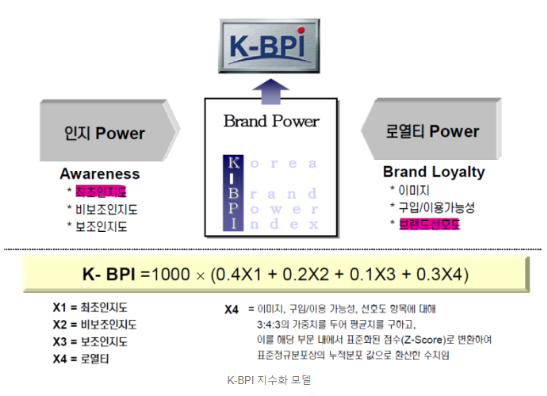

In [217]:
pdde['br_c'].fillna('기타',inplace = True)

In [218]:
# br_c별 구매횟수로 브랜드 인지로 파악
pdde_pivot = pdde.pivot_table(index = 'cust', columns = 'br_c', values = 'buy_ct',aggfunc = np.sum)#.fillna(0,inplace = True)
pdde_pivot.fillna(0,inplace =  True)

# cop_u는 구매횟수 데이터가 없어 data sample 하나를 구매 횟수로 보고 브랜드 인지도 파악
cop_u_pivot = cop_u.pivot_table(index = 'cust', columns = 'br_c', values = 'buy_am',aggfunc = 'count')#.fillna(0,inplace = True)
cop_u_pivot.fillna(0,inplace = True)

In [219]:
# (고객 거래량에 의한 브랜드 파워) [브랜드 선호도]
pdde_brand_preference = (pdde_pivot.max(axis = 1)/pdde_pivot.sum(axis = 1))
cop_u_brand_preference = (cop_u_pivot.max(axis = 1)/cop_u_pivot.sum(axis = 1))

In [220]:
pdde_brand_preference

cust
M000034966    0.811321
M000136117    0.653465
M000201112    0.517241
M000225114    0.930636
M000261625    0.771429
                ...   
M999599111    0.767442
M999673157    0.350000
M999770689    0.338624
M999849895    0.379310
M999962961    0.479012
Length: 26850, dtype: float64

In [221]:
pdde_a = pdde.groupby('br_c')['buy_am'].sum().sort_values(ascending = False).reset_index()
pdde_b = pdde.groupby('br_c')['buy_ct'].sum().sort_values(ascending = False).reset_index()
pdde_df = pd.merge(pdde_a, pdde_b, on = 'br_c')
pdde_c = (pdde_df.buy_am / pdde_df.buy_ct).astype(int)
pdde_df = pd.concat([pdde_df, pdde_c], axis = 1)
pdde_df = pdde_df.rename(columns = {0:'pdde_amount'})

cop_u_df = cop_u.groupby('br_c')['buy_am'].mean().sort_values(ascending = False).astype(int).reset_index()
cop_u_df = cop_u_df.rename(columns = {'buy_am':'cop_u_amount'})

In [222]:
pdde_brand_pivot = []
for i in range(pdde_pivot.shape[0]):
    pdde_brand_pivot.append(pdde_pivot.columns[np.argmax(pdde_pivot.iloc[i,:])])
    
cop_u_brand_pivot = []
for i in range(cop_u_pivot.shape[0]):
    cop_u_brand_pivot.append(cop_u_pivot.columns[np.argmax(cop_u_pivot.iloc[i,:])])

In [223]:
# 품목(br_c) 1개의 평균 금액 (순수 가격에 의한 브랜드 파워) [최초 인지도]
pdde_brand_amount = pd.Series(pdde_brand_pivot).apply(lambda x : pdde_df.loc[pdde_df['br_c'] == x ,'pdde_amount'].values[0])
cop_u_brand_amount = pd.Series(cop_u_brand_pivot).apply(lambda x : cop_u_df.loc[cop_u_df['br_c'] == x ,'cop_u_amount'].values[0])

In [224]:
pdde_brand = (pdde_pivot.max(axis = 1)/pdde_pivot.sum(axis = 1))*pdde_brand_amount.values
pdde_brand = pdde_brand.reset_index().rename(columns = {0 : 'pdde_브랜드파워'})
pdde_brand['pdde_브랜드파워'] = pdde_brand.pdde_브랜드파워.astype(int)

cop_u_brand = (cop_u_pivot.max(axis = 1)/cop_u_pivot.sum(axis = 1))*cop_u_brand_amount.values
cop_u_brand = cop_u_brand.reset_index().rename(columns = {0 : 'cop_u_브랜드파워'})
cop_u_brand['cop_u_브랜드파워'] = cop_u_brand.cop_u_브랜드파워.astype(int)

In [225]:
print('# pdde_브랜드파워 #  _1사분위_ :', pdde_brand.pdde_브랜드파워.describe()[4], '  _2사분위_ :', pdde_brand.pdde_브랜드파워.describe()[5], '  _3사분위_ :', pdde_brand.pdde_브랜드파워.describe()[6])
print('# cop_u_브랜드파워 #  _1사분위_ :', cop_u_brand.cop_u_브랜드파워.describe()[4], '  _2사분위_ :', cop_u_brand.cop_u_브랜드파워.describe()[5], '  _3사분위_ :', cop_u_brand.cop_u_브랜드파워.describe()[6])

# pdde_브랜드파워 #  _1사분위_ : 2487.0   _2사분위_ : 4201.0   _3사분위_ : 15624.0
# cop_u_브랜드파워 #  _1사분위_ : 4959.0   _2사분위_ : 7545.0   _3사분위_ : 10445.0


In [226]:
def pdde_브랜드파워(x):
    if x >= 15624:
        x = 5 - (1- x/1191350)
    elif 15624 > x >= 4201:
        x = 4 - (1 - x/15624)
    elif 4201 > x >= 2487:
        x = 3 - (1 - x/4201)
    elif x <= 2487:
        x = 2- (1 - x/2487)
    return round(x, 2)

def cop_u_브랜드파워(x):
    if x >= 10445:
        x = 5 - (1- x/467604)
    elif 10445 > x >= 7545:
        x = 4 - (1 - x/10445)
    elif 7545 > x >= 4959:
        x = 3 - (1 - x/7545)
    elif x <= 4959:
        x = 2- (1 - x/4959)
    return round(x, 2)

In [227]:
pdde_brand['pdde_브랜드파워'] = pdde_brand.pdde_브랜드파워.apply(lambda x : pdde_브랜드파워(x))
cop_u_brand['cop_u_브랜드파워'] = cop_u_brand.cop_u_브랜드파워.apply(lambda x : cop_u_브랜드파워(x))

In [228]:
demo = pd.merge(demo, pdde_brand, on = 'cust', how = 'outer').fillna(0)
demo = pd.merge(demo, cop_u_brand, on = 'cust', how = 'outer').fillna(0)

In [229]:
gc.collect()

0

In [230]:
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,lpay_pdde_only,lpay_cop_only,lpay_both,pdde_소비적극성,cop_u_소비적극성,소비충동성,가격민감성,pdde_브랜드파워,cop_u_브랜드파워
0,M000034966,여성,40대,Z07,0,0,0,1.74,1.00,4.22,2.48,3.29,4.03
1,M000136117,여성,30대,Z11,0,0,1,2.40,3.14,3.29,2.25,4.05,4.03
2,M000201112,여성,50대,Z17,0,0,0,1.83,0.00,4.05,2.63,1.41,0.00
3,M000225114,여성,40대,Z17,0,0,0,3.27,1.76,4.22,3.29,4.04,3.89
4,M000261625,여성,40대,Z17,0,0,0,2.25,1.00,2.98,2.46,4.03,3.83


___

## 5) 광고와 홍보

`< 외부데이터 URL >`  
https://kosis.kr/statHtml/statHtml.do?orgId=423&tblId=DT_423002_005&vw_cd=MT_ZTITLE&list_id=O_2&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=MT_ZTITLE&path=%252FstatisticsList%252FstatisticsListIndex.do  

2021.1월 ~ 12월 종합매체에 대한 업종별 광고경기동향지수  
__품목별 광고경기동향 지수가 좋다 -> 소비자들이 광고에 영향을 받았다__ 라고 판단  

__< 계산 방법 >__  
scaling(월별 품목별 구매여부 + 전 월 대비 경기동향지수 증감률)  

__< 참고자료 >__  

- 이용자용 통계정보보고서_광고경기전망지수조사  

http://kostat.go.kr/assist/synap/preview/skin/miri.html?fn=d214374491196601021420&rs=/assist/synap/preview
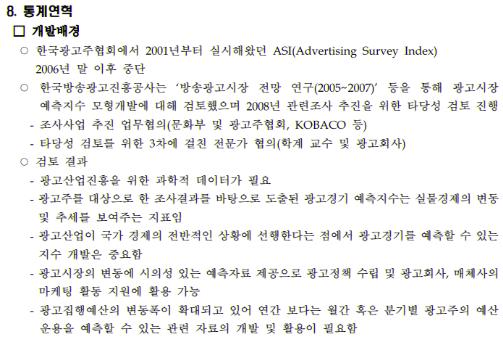

-> "광고경기예측지수는 실물경제의 변동 및 추세를 보여주는 지표"

### 품목 전처리

In [231]:
pd_clac['item'] = pd_clac.clac_hlv_nm

In [232]:
pd_clac['item'] = pd_clac['item'].replace(['건강식품','건해산물','과일','과자','냉동식품','냉장식품',
                        '대용식','병통조림','수산물','유제품','음료','조리식품','담배',
                        '조미료','주류','채소','축산물','커피/차','유아식품','양곡'], '식료품')

pd_clac['item'] = pd_clac['item'].replace(['남성의류','속옷/양말/홈웨어','스포츠패션','여성의류',
                        '유아동의류','패션잡화','화장품/뷰티케어'], '의류/신발')

pd_clac['item'] = pd_clac['item'].replace(['구기/필드스포츠','서적/음반/악기','시즌스포츠',
                        '아웃도어/레저','원예/애완','퍼스널케어','헬스/피트니스','완구',
                        '여행/레저서비스','문구/사무용품',], '오락/문화')

pd_clac['item'] = pd_clac['item'].replace(['모바일','컴퓨터','자동차용품'], '통신/교통')

pd_clac['item'] = pd_clac['item'].replace(['가구','계절가전','냉장/세탁가전','공구/안전용품',
                        '생활/렌탈서비스','생활/주방가전','세제/위생','식기/조리기구',
                        '인테리어/조명','주방잡화','청소/세탁/욕실용품','침구/수예',
                        '영상/음향가전','테넌트/음식점'], '음식/숙박')

pd_clac['item'] = pd_clac['item'].replace(['금융/보험서비스','기타(비상품)','기타상품','상품권',
                        '건강용품','출산/육아용품'], '기타')
pd_clac['item'].unique()

array(['음식/숙박', '식료품', '기타', '오락/문화', '의류/신발', '통신/교통'], dtype=object)

In [233]:
item = pd_clac[['pd_c','item']]

In [234]:
pdde_item = pd.merge(pdde,item,on = 'pd_c')

In [235]:
pdde_item['month'] = pdde_item.de_dt.apply(lambda x : x.month)

In [236]:
pdde_item = pdde_item[['cust', 'buy_am','item','month']]

<AxesSubplot:ylabel='item'>

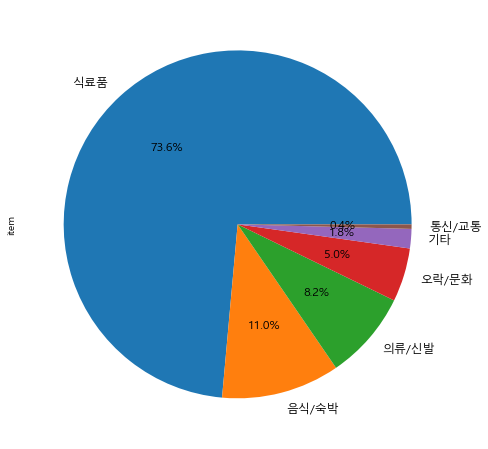

In [250]:
pdde_item.item.value_counts().plot.pie(figsize = (12,8), autopct = '%.1f%%', fontsize = 12)

### 광고경기동향지수

In [238]:
adv = pd.read_csv('전월대비_매체별_업종별_광고경기동향지수_20220718153645.csv', encoding='cp949')
adv = adv.iloc[2:,:].reset_index().iloc[:,1:]

In [242]:
adv

,업종명,_2020_12,_2021_1,_2021_2,_2021_3,_2021_4,_2021_5,_2021_6,_2021_7,_2021_8,_2021_9,_2021_10,_2021_11,_2021_12
0,가정용품 및 가사서비스,95.5,103.6,128.6,106.9,79.3,100.0,106.7,110.0,93.3,120.7,111.1,97.6,90.5
1,교육 및 사회복지서비스,126.1,110.0,87.5,95.3,104.5,116.7,119.0,115.4,125.6,125.0,85.0,112.5,118.2
2,금융 및 보험서비스,110.0,90.9,97.4,97.6,90.2,124.4,115.4,100.0,121.4,94.9,96.0,93.0,106.4
3,기타상품 및 서비스,110.0,110.3,96.6,120.7,100.0,104.3,96.3,89.3,96.6,110.0,100.0,97.1,112.1
4,문화오락용품 및 관련서비스,103.0,81.4,109.1,106.7,128.0,101.8,95.9,85.7,102.0,106.7,105.5,107.4,108.9
5,미용용품 및 미용서비스,94.7,100.0,100.0,133.3,113.3,121.4,116.7,84.6,92.9,106.7,111.1,94.7,105.6
6,비영리단체 및 공공기관,106.3,59.2,114.4,116.1,112.4,108.9,117.6,100.0,103.8,113.0,108.4,112.4,92.3
7,식료품 및 비주류음료,104.2,104.0,100.0,126.1,119.1,112.2,108.2,108.3,107.7,112.8,91.4,93.5,100.0
8,신문 서적 및 문구류,111.8,116.7,83.3,100.0,116.7,105.6,88.9,100.0,92.9,100.0,94.4,100.0,105.9
9,운송장비,110.0,80.0,90.0,130.0,140.0,120.0,80.0,90.9,66.7,53.8,69.2,87.5,92.3


In [239]:
adv.columns = ['업종명', '_2020_12','_2021_1', '_2021_2','_2021_3','_2021_4','_2021_5','_2021_6','_2021_7','_2021_8','_2021_9','_2021_10','_2021_11','_2021_12',]

In [240]:
adv['_2020_12'] = adv._2020_12.astype(float)
adv['_2021_1'] = adv._2021_1.astype(float)
adv['_2021_2'] = adv._2021_2.astype(float)
adv['_2021_3'] = adv._2021_3.astype(float)
adv['_2021_4'] = adv._2021_4.astype(float)
adv['_2021_5'] = adv._2021_5.astype(float)
adv['_2021_6'] = adv._2021_6.astype(float)
adv['_2021_7'] = adv._2021_7.astype(float)
adv['_2021_8'] = adv._2021_8.astype(float)
adv['_2021_9'] = adv._2021_9.astype(float)
adv['_2021_10'] = adv._2021_10.astype(float)
adv['_2021_11'] = adv._2021_11.astype(float)
adv['_2021_12'] = adv._2021_12.astype(float)

In [251]:
adv.head()

,업종명,_2020_12,_2021_1,_2021_2,_2021_3,_2021_4,_2021_5,_2021_6,_2021_7,_2021_8,_2021_9,_2021_10,_2021_11,_2021_12
0,가정용품 및 가사서비스,95.5,103.6,128.6,106.9,79.3,100.0,106.7,110.0,93.3,120.7,111.1,97.6,90.5
1,교육 및 사회복지서비스,126.1,110.0,87.5,95.3,104.5,116.7,119.0,115.4,125.6,125.0,85.0,112.5,118.2
2,금융 및 보험서비스,110.0,90.9,97.4,97.6,90.2,124.4,115.4,100.0,121.4,94.9,96.0,93.0,106.4
3,기타상품 및 서비스,110.0,110.3,96.6,120.7,100.0,104.3,96.3,89.3,96.6,110.0,100.0,97.1,112.1
4,문화오락용품 및 관련서비스,103.0,81.4,109.1,106.7,128.0,101.8,95.9,85.7,102.0,106.7,105.5,107.4,108.9


전처리한 품목에 알맞은 `광고경기동향지수` 내의 품목들 지정

* __식료품__ 
    * 식료품 및 비주류음료  
    * 주류 및 담배  


* __의류/신발__  
    * 의류 및 신발  
    * 미용용품 및 미용서비스  
    
    
* __오락/문화__  
    * 문화오락용품 및 관련서비스  
    * 신문 서적 및 문구류  


* __통신/교통__  
    * 통신  
    * 운송장비  
    * 정보처리장비  


* __음식/숙박__  
    * 음식 및 숙박, 운수서비스  
    

* __기타__  
    * 기타상품 및 서비스  
    * 의료용품 및 장비,의료서비스

In [252]:
adv.replace('식료품 및 비주류음료', '식료품', inplace = True)
adv.replace('주류 및 담배', '식료품', inplace = True)

adv.replace('의류 및 신발', '의류/신발', inplace = True)
adv.replace('미용용품 및 미용서비스', '의류/신발', inplace = True)

adv.replace('문화오락용품 및 관련서비스', '오락/문화', inplace = True)
adv.replace('신문 서적 및 문구류', '오락/문화', inplace = True)

adv.replace('통신', '통신/교통', inplace = True)
adv.replace('운송장비', '통신/교통', inplace = True)
adv.replace('정보처리장비', '통신/교통', inplace = True)

adv.replace('음식 및 숙박, 운수서비스', '음식/숙박', inplace = True)

adv.replace('기타상품 및 서비스', '기타', inplace = True)
adv.replace('의료용품 및 장비, 의료서비스', '기타', inplace = True)

In [253]:
식료품 = round(adv.query('업종명 == "식료품"').iloc[:,1:].mean().reset_index().T.iloc[1:,:].astype(float), 2)
의류_신발 = round(adv.query('업종명 == "의류/신발"').iloc[:,1:].mean().reset_index().T.iloc[1:,:].astype(float),2)
오락_문화 = round(adv.query('업종명 == "오락/문화"').iloc[:,1:].mean().reset_index().T.iloc[1:,:].astype(float),2)
통신_교통 = round(adv.query('업종명 == "통신/교통"').iloc[:,1:].mean().reset_index().T.iloc[1:,:].astype(float),2)
음식_숙박 = round(adv.query('업종명 == "음식/숙박"').iloc[:,1:].mean().reset_index().T.iloc[1:,:].astype(float),2)
기타 = round(adv.query('업종명 == "기타"').iloc[:,1:].mean().reset_index().T.iloc[1:,:].astype(float),2)

식료품.columns = ['_2020_12','_2021_1', '_2021_2','_2021_3','_2021_4','_2021_5','_2021_6','_2021_7','_2021_8','_2021_9','_2021_10','_2021_11','_2021_12']
의류_신발.columns = ['_2020_12','_2021_1', '_2021_2','_2021_3','_2021_4','_2021_5','_2021_6','_2021_7','_2021_8','_2021_9','_2021_10','_2021_11','_2021_12']
오락_문화.columns = ['_2020_12','_2021_1', '_2021_2','_2021_3','_2021_4','_2021_5','_2021_6','_2021_7','_2021_8','_2021_9','_2021_10','_2021_11','_2021_12']
통신_교통.columns = ['_2020_12','_2021_1', '_2021_2','_2021_3','_2021_4','_2021_5','_2021_6','_2021_7','_2021_8','_2021_9','_2021_10','_2021_11','_2021_12']
음식_숙박.columns = ['_2020_12','_2021_1', '_2021_2','_2021_3','_2021_4','_2021_5','_2021_6','_2021_7','_2021_8','_2021_9','_2021_10','_2021_11','_2021_12']
기타.columns = ['_2020_12','_2021_1', '_2021_2','_2021_3','_2021_4','_2021_5','_2021_6','_2021_7','_2021_8','_2021_9','_2021_10','_2021_11','_2021_12']

In [254]:
a = pd.concat([식료품,의류_신발,오락_문화,통신_교통,음식_숙박,기타], axis = 0).reset_index().iloc[:,1:]
b = pd.DataFrame({'업종명' : ['식료품','의류/신발','오락/문화','통신/교통','음식/숙박','기타']})

adv = pd.concat([b, a], axis = 1)

In [255]:
adv

,업종명,_2020_12,_2021_1,_2021_2,_2021_3,_2021_4,_2021_5,_2021_6,_2021_7,_2021_8,_2021_9,_2021_10,_2021_11,_2021_12
0,식료품,106.65,92.00,85.00,104.70,109.55,121.10,99.10,84.15,103.85,111.40,85.70,105.85,90.90
1,의류/신발,88.00,78.55,104.75,128.55,115.75,106.85,103.80,100.00,92.90,128.35,115.05,95.20,98.65
2,오락/문화,107.40,99.05,96.20,103.35,122.35,103.70,92.40,92.85,97.45,103.35,99.95,103.70,107.40
3,통신/교통,106.37,81.20,97.27,110.47,115.13,103.90,93.33,90.90,91.93,87.63,86.97,96.40,100.20
4,음식/숙박,106.70,70.60,105.90,100.00,118.80,100.00,93.30,100.00,73.30,125.00,95.80,104.20,100.00
5,기타,102.60,116.25,95.80,112.85,107.50,104.65,102.90,97.05,89.20,118.65,104.85,98.55,106.05


### 월별 품목별 구매여부

In [256]:
df_ps = pd.pivot_table(pdde_item, index = 'cust', columns = ['month', 'item'], values = 'buy_am', aggfunc = np.size, fill_value = 0)

In [257]:
df_ps = df_ps/df_ps
df_ps = df_ps.fillna(0).astype(int)

In [258]:
# item columns 순서 확인
df_ps.columns.get_level_values(1)[:6]

Index(['기타', '식료품', '오락/문화', '음식/숙박', '의류/신발', '통신/교통'], dtype='object', name='item')

In [259]:
# multi index 삭제
df_ps.columns = df_ps.columns.droplevel(0)

In [260]:
# columns명 변경
lst = []
for i in range(1,13):    
    for j in list(df_ps.iloc[:,:6:].columns):
        a = str(i)+'월_'+j
        lst.append(a)
        #print(i,'월_' + j)
        
df_ps.columns = lst

In [282]:
df_ps.iloc[:,4::6].head()

,1월_의류/신발,2월_의류/신발,3월_의류/신발,4월_의류/신발,5월_의류/신발,6월_의류/신발,7월_의류/신발,8월_의류/신발,9월_의류/신발,10월_의류/신발,11월_의류/신발,12월_의류/신발
cust,,,,,,,,,,,,
M000034966,1,0,1,0,0,1,0,0,0,0,0,0
M000136117,1,1,1,0,1,1,1,1,0,1,0,1
M000201112,0,0,0,0,0,0,0,0,0,0,0,0
M000225114,0,0,1,1,0,0,1,0,1,1,1,0
M000261625,1,1,1,1,1,1,1,1,1,1,1,1


In [262]:
gc.collect()

26

### 전 월 대비 경기동향지수 증감률

In [263]:
업종명 = adv.업종명
roc = adv.T.iloc[1:,:].pct_change().iloc[1:,:].T

weight = round(pd.concat([업종명, roc], axis = 1),2)
weight

,업종명,_2021_1,_2021_2,_2021_3,_2021_4,_2021_5,_2021_6,_2021_7,_2021_8,_2021_9,_2021_10,_2021_11,_2021_12
0,식료품,-0.14,-0.08,0.23,0.05,0.11,-0.18,-0.15,0.23,0.07,-0.23,0.24,-0.14
1,의류/신발,-0.11,0.33,0.23,-0.10,-0.08,-0.03,-0.04,-0.07,0.38,-0.10,-0.17,0.04
2,오락/문화,-0.08,-0.03,0.07,0.18,-0.15,-0.11,0.00,0.05,0.06,-0.03,0.04,0.04
3,통신/교통,-0.24,0.20,0.14,0.04,-0.10,-0.10,-0.03,0.01,-0.05,-0.01,0.11,0.04
4,음식/숙박,-0.34,0.50,-0.06,0.19,-0.16,-0.07,0.07,-0.27,0.71,-0.23,0.09,-0.04
5,기타,0.13,-0.18,0.18,-0.05,-0.03,-0.02,-0.06,-0.08,0.33,-0.12,-0.06,0.08


In [281]:
weight

,업종명,_2021_1,_2021_2,_2021_3,_2021_4,_2021_5,_2021_6,_2021_7,_2021_8,_2021_9,_2021_10,_2021_11,_2021_12
0,식료품,-0.14,-0.08,0.23,0.05,0.11,-0.18,-0.15,0.23,0.07,-0.23,0.24,-0.14
1,의류/신발,-0.11,0.33,0.23,-0.10,-0.08,-0.03,-0.04,-0.07,0.38,-0.10,-0.17,0.04
2,오락/문화,-0.08,-0.03,0.07,0.18,-0.15,-0.11,0.00,0.05,0.06,-0.03,0.04,0.04
3,통신/교통,-0.24,0.20,0.14,0.04,-0.10,-0.10,-0.03,0.01,-0.05,-0.01,0.11,0.04
4,음식/숙박,-0.34,0.50,-0.06,0.19,-0.16,-0.07,0.07,-0.27,0.71,-0.23,0.09,-0.04
5,기타,0.13,-0.18,0.18,-0.05,-0.03,-0.02,-0.06,-0.08,0.33,-0.12,-0.06,0.08


### 구매여부 + 증감률

In [264]:
main = demo['cust']
for i in range(0,72,6):
    a = df_ps.iloc[:,i:i+6] # 월 설정
    for j in range(6):
        b = weight.iloc[j,int(i/6)+1] # 가중치 설정
        df_mul = a + (1+b)
    main = pd.merge(main, df_mul, on = 'cust').fillna(0)
    
main.head()

,cust,1월_기타,1월_식료품,1월_오락/문화,1월_음식/숙박,1월_의류/신발,1월_통신/교통,2월_기타,2월_식료품,2월_오락/문화,...,11월_오락/문화,11월_음식/숙박,11월_의류/신발,11월_통신/교통,12월_기타,12월_식료품,12월_오락/문화,12월_음식/숙박,12월_의류/신발,12월_통신/교통
0,M000034966,1.13,2.13,1.13,1.13,2.13,1.13,0.82,0.82,0.82,...,0.94,0.94,0.94,0.94,1.08,2.08,2.08,1.08,1.08,1.08
1,M000136117,1.13,2.13,2.13,2.13,2.13,1.13,0.82,1.82,0.82,...,0.94,0.94,0.94,0.94,1.08,1.08,2.08,1.08,2.08,1.08
2,M000201112,1.13,1.13,1.13,1.13,1.13,1.13,0.82,0.82,0.82,...,0.94,0.94,0.94,0.94,1.08,1.08,1.08,1.08,1.08,1.08
3,M000225114,1.13,1.13,1.13,1.13,1.13,1.13,0.82,0.82,0.82,...,0.94,1.94,1.94,0.94,1.08,2.08,1.08,2.08,1.08,1.08
4,M000261625,1.13,1.13,1.13,1.13,2.13,1.13,0.82,1.82,1.82,...,0.94,0.94,1.94,0.94,1.08,1.08,1.08,2.08,2.08,1.08


In [291]:
a = main.cust
b = main.iloc[:,1:].sum(axis = 1).reset_index().iloc[:,1:].rename(columns={0:'광고와홍보'})

In [292]:
b = round(b/139.72, 2) *5 # 0~1 scaling

In [267]:
광고_홍보 = pd.concat([a, b], axis = 1)

In [268]:
demo = pd.merge(demo, 광고_홍보, on = 'cust', how ='outer').fillna(0)

___

## 6) 평일 시간대별 소비력

In [296]:
pdde['day'] = pdde.de_dt.apply(lambda x : x.weekday())
cop_u['day'] = cop_u.de_dt.apply(lambda x : x.weekday())

In [297]:
pdde_평일오전 = pdde.query('1<=day<=5 & de_hr<12').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'pdde_평일_오전소비력'})
pdde_평일오후 = pdde.query('1<=day<=5 & 12<=de_hr<18').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'pdde_평일_오후소비력'})
pdde_평일저녁 = pdde.query('1<=day<=5 & de_hr>=18').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'pdde_평일_저녁소비력'})

cop_u_평일오전 = cop_u.query('1<=day<=5 & de_hr<12').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'cop_u_평일_오전소비력'})
cop_u_평일오후 = cop_u.query('1<=day<=5 & 12<=de_hr<18').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'cop_u_평일_오후소비력'})
cop_u_평일저녁 = cop_u.query('1<=day<=5 & de_hr>=18').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'cop_u_평일_저녁소비력'})

In [298]:
평일 = [1,2,3,4,5]
pdde_주말오전 = pdde.query('day != @평일 & de_hr<12').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'pdde_주말_오전소비력'})
pdde_주말오후 = pdde.query('day != @평일 & 12<=de_hr<18').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'pdde_주말_오후소비력'})
pdde_주말저녁 = pdde.query('day != @평일 & de_hr>=18').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'pdde_주말_저녁소비력'})

cop_u_주말오전 = cop_u.query('day != @평일 & de_hr<12').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'cop_u_주말_오전소비력'})
cop_u_주말오후 = cop_u.query('day != @평일 & 12<=de_hr<18').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'cop_u_주말_오후소비력'})
cop_u_주말저녁 = cop_u.query('day != @평일 & de_hr>=18').groupby('cust')['buy_am'].sum().reset_index().rename(columns = {'buy_am':'cop_u_주말_저녁소비력'})

In [313]:
asd = pd.merge(pdde_평일오전, pdde_평일오후, on = 'cust', how = 'outer')
asd = pd.merge(asd, pdde_평일저녁, on = 'cust', how = 'outer')
asd = asd.fillna(0)

In [314]:
asd

,cust,pdde_평일_오전소비력,pdde_평일_오후소비력,pdde_평일_저녁소비력
0,M000136117,235200.0,17205260.0,3165300.0
1,M000201112,10120.0,0.0,4300.0
2,M000225114,50900.0,416670.0,1183350.0
3,M000261625,238000.0,3175300.0,1266600.0
4,M000350564,1819600.0,2190200.0,895800.0
...,...,...,...,...
26076,M990507479,0.0,0.0,519662.0
26077,M992165679,0.0,0.0,3300.0
26078,M992635708,0.0,0.0,202400.0
26079,M995528586,0.0,0.0,57600.0


In [310]:
asd = pd.merge(pdde_주말오전, pdde_주말오후, on = 'cust', how = 'outer')
asd = pd.merge(asd, pdde_주말저녁, on = 'cust', how = 'outer')
asd = asd.fillna(0)

In [312]:
asd

,cust,pdde_주말_오전소비력,pdde_주말_오후소비력,pdde_주말_저녁소비력
0,M000136117,74100.0,3490770.0,0.0
1,M000261625,220000.0,1148900.0,0.0
2,M000419293,10000.0,63900.0,298800.0
3,M000494848,225130.0,1909304.0,433300.0
4,M000555652,211900.0,540800.0,0.0
...,...,...,...,...
24056,M994879948,0.0,0.0,119120.0
24057,M997082506,0.0,0.0,39000.0
24058,M997530364,0.0,0.0,27140.0
24059,M998129365,0.0,0.0,164000.0


In [299]:
demo = pd.merge(demo, pdde_평일오전, on = 'cust', how = 'outer')
demo = pd.merge(demo, pdde_평일오후, on = 'cust', how = 'outer')
demo = pd.merge(demo, pdde_평일저녁, on = 'cust', how = 'outer')

demo = pd.merge(demo, cop_u_평일오전, on = 'cust', how = 'outer')
demo = pd.merge(demo, cop_u_평일오후, on = 'cust', how = 'outer')
demo = pd.merge(demo, cop_u_평일저녁, on = 'cust', how = 'outer')

In [300]:
demo = pd.merge(demo, pdde_주말오전, on = 'cust', how = 'outer')
demo = pd.merge(demo, pdde_주말오후, on = 'cust', how = 'outer')
demo = pd.merge(demo, pdde_주말저녁, on = 'cust', how = 'outer')

demo = pd.merge(demo, cop_u_주말오전, on = 'cust', how = 'outer')
demo = pd.merge(demo, cop_u_주말오후, on = 'cust', how = 'outer')
demo = pd.merge(demo, cop_u_주말저녁, on = 'cust', how = 'outer')

In [301]:
demo = demo.fillna(0)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,lpay_pdde_only,lpay_cop_only,lpay_both,pdde_소비적극성,cop_u_소비적극성,소비충동성,...,pdde_평일_저녁소비력,cop_u_평일_오전소비력,cop_u_평일_오후소비력,cop_u_평일_저녁소비력,pdde_주말_오전소비력,pdde_주말_오후소비력,pdde_주말_저녁소비력,cop_u_주말_오전소비력,cop_u_주말_오후소비력,cop_u_주말_저녁소비력
0,M000034966,여성,40대,Z07,0,0,0,1.74,1.00,4.22,...,240920.0,3900.0,0.0,0.0,0.0,125550.0,89560.0,0.0,0.0,0.0
1,M000136117,여성,30대,Z11,0,0,1,2.40,3.14,3.29,...,3165300.0,14300.0,81300.0,75100.0,74100.0,3490770.0,0.0,38400.0,0.0,28300.0
2,M000201112,여성,50대,Z17,0,0,0,1.83,0.00,4.05,...,4300.0,0.0,0.0,0.0,0.0,37000.0,0.0,0.0,0.0,0.0
3,M000225114,여성,40대,Z17,0,0,0,3.27,1.76,4.22,...,1183350.0,0.0,107600.0,21100.0,0.0,22970.0,54180.0,67500.0,0.0,11000.0
4,M000261625,여성,40대,Z17,0,0,0,2.25,1.00,2.98,...,1266600.0,0.0,23250.0,0.0,220000.0,1148900.0,0.0,0.0,0.0,0.0


In [302]:
demo.isna().sum().sum()

0

___

## 7) 항목별 소비 성향 분석

소비패턴

- 오락/문화
- 식료품 
- 통신/교통 
- 음식/숙박 
- 의류/신발 
- 기타 

In [315]:
pdde_item.head()

,cust,buy_am,item,month
0,M430112881,15000,의류/신발,1
1,M430112881,19000,의류/신발,1
2,M430112881,19000,의류/신발,1
3,M506355556,199000,의류/신발,1
4,M900002349,96000,의류/신발,1


In [316]:
pdde_item_pivot = pd.pivot_table(pdde_item, index = 'cust', columns = 'item', values = 'buy_am', aggfunc = np.sum, fill_value = 0)

In [317]:
pdde_item_pivot.columns = ['기타_소비력', '식료품_소비력', '오락/문화_소비력', '음식/숙박_소비력', '의류/신발_소비력', '통신/교통_소비력']

In [318]:
demo = pd.merge(demo, pdde_item_pivot, on = 'cust',how = 'outer').fillna(0)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,lpay_pdde_only,lpay_cop_only,lpay_both,pdde_소비적극성,cop_u_소비적극성,소비충동성,...,pdde_주말_저녁소비력,cop_u_주말_오전소비력,cop_u_주말_오후소비력,cop_u_주말_저녁소비력,기타_소비력,식료품_소비력,오락/문화_소비력,음식/숙박_소비력,의류/신발_소비력,통신/교통_소비력
0,M000034966,여성,40대,Z07,0,0,0,1.74,1.00,4.22,...,89560.0,0.0,0.0,0.0,0.0,152630.0,79200.0,1400.0,339200.0,0.0
1,M000136117,여성,30대,Z11,0,0,1,2.40,3.14,3.29,...,0.0,38400.0,0.0,28300.0,0.0,81320.0,584500.0,1625410.0,21520400.0,359000.0
2,M000201112,여성,50대,Z17,0,0,0,1.83,0.00,4.05,...,0.0,0.0,0.0,0.0,20.0,49700.0,0.0,1700.0,0.0,0.0
3,M000225114,여성,40대,Z17,0,0,0,3.27,1.76,4.22,...,54180.0,67500.0,0.0,11000.0,0.0,760820.0,0.0,93700.0,873550.0,0.0
4,M000261625,여성,40대,Z17,0,0,0,2.25,1.00,2.98,...,0.0,0.0,0.0,0.0,0.0,35200.0,503000.0,445800.0,3884900.0,1179900.0


In [399]:
demo

,cust,성별,연령,zon_hlv,lpay_pdde_only,lpay_cop_only,lpay_both,pdde_소비적극성,cop_u_소비적극성,소비충동성,...,통신/교통_소비력,브랜드파워,소비적극성,평일_오전소비력,평일_오후소비력,평일_저녁소비력,주말_오전소비력,주말_오후소비력,주말_저녁소비력,persona
0,M000034966,여성,40대,Z07,0,0,0,1.74,1.00,4.22,...,0.0,3.660,1.370,1950.0,58200.0,120460.0,0.0,62775.0,44780.0,40대_no7
1,M000136117,여성,30대,Z11,0,0,1,2.40,3.14,3.29,...,359000.0,4.040,2.770,124750.0,8643280.0,1620200.0,56250.0,1745385.0,14150.0,30대_no10
2,M000201112,여성,50대,Z17,0,0,0,1.83,0.00,4.05,...,0.0,0.705,0.915,5060.0,0.0,2150.0,0.0,18500.0,0.0,50대_no3
3,M000225114,여성,40대,Z17,0,0,0,3.27,1.76,4.22,...,0.0,3.965,2.515,25450.0,262135.0,602225.0,33750.0,11485.0,32590.0,40대_no7
4,M000261625,여성,40대,Z17,0,0,0,2.25,1.00,2.98,...,1179900.0,3.930,1.625,119000.0,1599275.0,633300.0,110000.0,574450.0,0.0,40대_no7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29696,M999708287,여성,40대,Z10,0,0,0,0.00,1.00,0.00,...,0.0,2.015,0.500,0.0,13000.0,0.0,0.0,0.0,0.0,40대_no3
29697,M999770689,여성,30대,Z16,0,0,1,4.40,2.18,4.09,...,0.0,2.930,3.290,126290.0,165890.0,243385.0,26155.0,131720.0,13605.0,30대_no10
29698,M999849895,여성,20대,Z04,0,0,0,2.25,1.00,3.69,...,15500.0,2.855,1.625,26100.0,371246.0,150310.0,0.0,0.0,0.0,20대_no7
29699,M999926092,남성,30대,Z08,0,0,0,0.00,1.74,0.00,...,0.0,1.460,0.870,0.0,30500.0,27200.0,0.0,7050.0,0.0,30대_no7


In [402]:
demo[['cust','기타_소비력','식료품_소비력', '오락/문화_소비력', '음식/숙박_소비력', '의류/신발_소비력', '통신/교통_소비력']]

,cust,기타_소비력,식료품_소비력,오락/문화_소비력,음식/숙박_소비력,의류/신발_소비력,통신/교통_소비력
0,M000034966,0.0,152630.0,79200.0,1400.0,339200.0,0.0
1,M000136117,0.0,81320.0,584500.0,1625410.0,21520400.0,359000.0
2,M000201112,20.0,49700.0,0.0,1700.0,0.0,0.0
3,M000225114,0.0,760820.0,0.0,93700.0,873550.0,0.0
4,M000261625,0.0,35200.0,503000.0,445800.0,3884900.0,1179900.0
...,...,...,...,...,...,...,...
29696,M999708287,0.0,0.0,0.0,0.0,0.0,0.0
29697,M999770689,43100.0,884600.0,30000.0,92740.0,127900.0,0.0
29698,M999849895,587450.0,278362.0,51000.0,53200.0,94800.0,15500.0
29699,M999926092,0.0,0.0,0.0,0.0,0.0,0.0


In [319]:
demo.columns

Index(['cust', 'ma_fem_dv', 'ages', 'zon_hlv', 'lpay_pdde_only',
       'lpay_cop_only', 'lpay_both', 'pdde_소비적극성', 'cop_u_소비적극성', '소비충동성',
       '가격민감성', 'pdde_브랜드파워', 'cop_u_브랜드파워', '광고와홍보', 'pdde_평일_오전소비력',
       'pdde_평일_오후소비력', 'pdde_평일_저녁소비력', 'cop_u_평일_오전소비력', 'cop_u_평일_오후소비력',
       'cop_u_평일_저녁소비력', 'pdde_주말_오전소비력', 'pdde_주말_오후소비력', 'pdde_주말_저녁소비력',
       'cop_u_주말_오전소비력', 'cop_u_주말_오후소비력', 'cop_u_주말_저녁소비력', '기타_소비력',
       '식료품_소비력', '오락/문화_소비력', '음식/숙박_소비력', '의류/신발_소비력', '통신/교통_소비력'],
      dtype='object')

In [320]:
demo.to_csv('demo[사용여부 관계, 소비적극성, 소비충동성, 가격민감성, 브랜드파워, 광고와 홍보, 요일별,시간대별 소비력, 품목별 소비력].csv', index = False)

In [404]:
demo = pd.read_csv('demo[사용여부 관계, 소비적극성, 소비충동성, 가격민감성, 브랜드파워, 광고와 홍보, 요일별,시간대별 소비력, 품목별 소비력].csv')

In [405]:
demo

,cust,ma_fem_dv,ages,zon_hlv,lpay_pdde_only,lpay_cop_only,lpay_both,pdde_소비적극성,cop_u_소비적극성,소비충동성,...,pdde_주말_저녁소비력,cop_u_주말_오전소비력,cop_u_주말_오후소비력,cop_u_주말_저녁소비력,기타_소비력,식료품_소비력,오락/문화_소비력,음식/숙박_소비력,의류/신발_소비력,통신/교통_소비력
0,M000034966,여성,40대,Z07,0,0,0,1.74,1.00,4.22,...,89560.0,0.0,0.0,0.0,0.0,152630.0,79200.0,1400.0,339200.0,0.0
1,M000136117,여성,30대,Z11,0,0,1,2.40,3.14,3.29,...,0.0,38400.0,0.0,28300.0,0.0,81320.0,584500.0,1625410.0,21520400.0,359000.0
2,M000201112,여성,50대,Z17,0,0,0,1.83,0.00,4.05,...,0.0,0.0,0.0,0.0,20.0,49700.0,0.0,1700.0,0.0,0.0
3,M000225114,여성,40대,Z17,0,0,0,3.27,1.76,4.22,...,54180.0,67500.0,0.0,11000.0,0.0,760820.0,0.0,93700.0,873550.0,0.0
4,M000261625,여성,40대,Z17,0,0,0,2.25,1.00,2.98,...,0.0,0.0,0.0,0.0,0.0,35200.0,503000.0,445800.0,3884900.0,1179900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29696,M999708287,여성,40대,Z10,0,0,0,0.00,1.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29697,M999770689,여성,30대,Z16,0,0,1,4.40,2.18,4.09,...,27210.0,7800.0,79000.0,0.0,43100.0,884600.0,30000.0,92740.0,127900.0,0.0
29698,M999849895,여성,20대,Z04,0,0,0,2.25,1.00,3.69,...,0.0,0.0,0.0,0.0,587450.0,278362.0,51000.0,53200.0,94800.0,15500.0
29699,M999926092,남성,30대,Z08,0,0,0,0.00,1.74,0.00,...,0.0,0.0,14100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [406]:
import seaborn as sns

<AxesSubplot:>

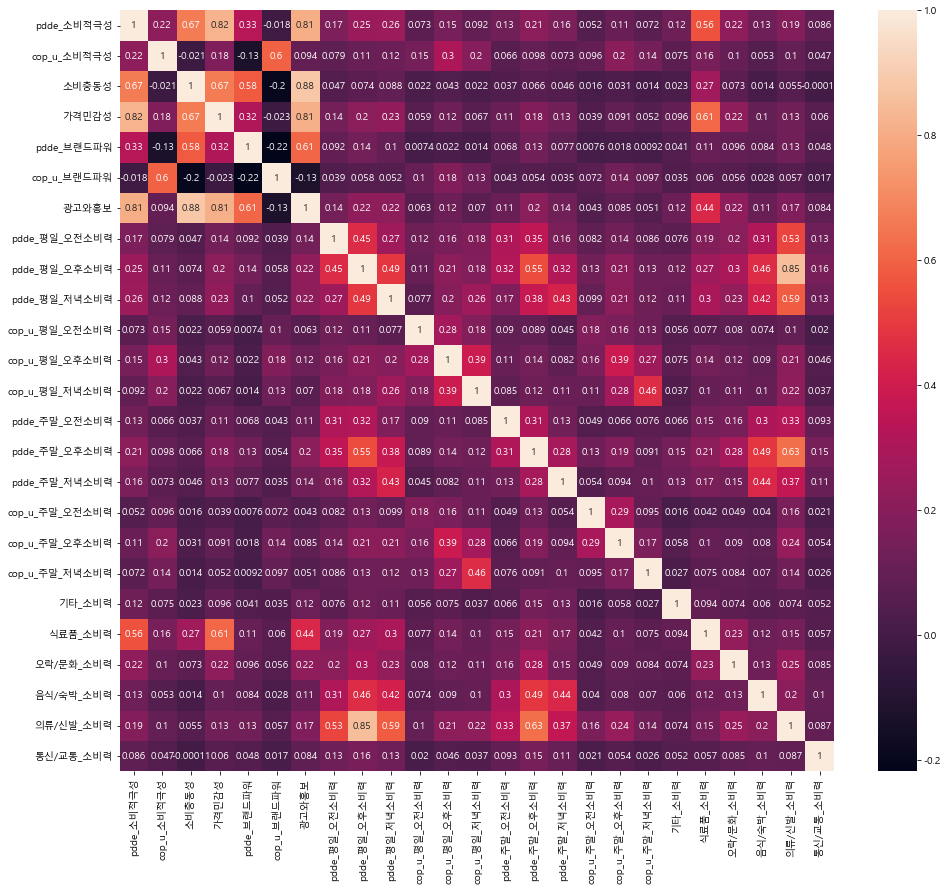

In [407]:
plt.figure(figsize = (16,14))
sns.heatmap(demo.iloc[:,7:].corr(), annot = True)

# 4. Persona classification

In [444]:
pdde.to_csv('pdde_추가.csv', index = False)

In [409]:
data  = pd.read_excel('외부유출 주의_페르소나DB.xlsx',header = 1)

In [411]:
per_columns = ['ID / 사진명','연령', '성별','평일오전 소비력','평일오후 소비력','평일저녁 소비력','소비력','소비력.1','소비력.2','오락.문화','식료품','통신.교통','음식.숙박','의류.신발','기타','소비 적극성.1','소비 충동성','광고와 홍보.1','브랜드 파워','가격 민감도']

In [412]:
data = data.loc[:120,per_columns]

In [414]:
def age(x):
    if x == '10~19' :
        x = '10대'
    elif x == '20~29' :
        x = '20대'
    elif x == '30~39' : 
        x = '30대'
    elif x == "40~49" :
        x = '40대'
    elif x == "50~59":
        x = '50대'
    else:
        x = '60대이상'
    return x

In [415]:
data['연령'] = data.연령.apply(lambda x : age(x))

In [417]:
data = data.rename(columns = {'소비력' : '주말_오전소비력','소비력.1' : '주말_오후소비력','소비력.2' : '주말_저녁소비력','오락.문화':'오락/문화_소비력','식료품':'식료품_소비력','음식.숙박' : '음식/숙박_소비력','의류.신발':'의류/신발_소비력','평일오전 소비력':
                       '평일_오전소비력','평일오후 소비력' : '평일_오후소비력','통신.교통' : '통신/교통_소비력','가격 민감도' : '가격민감성','브랜드 파워' : '브랜드파워','광고와 홍보.1' : '광고와홍보','소비 충동성' : '소비충동성','소비 적극성.1' : '소비적극성'
                       ,'기타' : '기타_소비력','평일저녁 소비력' : '평일_저녁소비력'}) 

In [418]:
demo['브랜드파워'] = (demo.pdde_브랜드파워 + demo.cop_u_브랜드파워) /2

In [419]:
demo['소비적극성'] = (demo.pdde_소비적극성 + demo.cop_u_소비적극성) /2

In [420]:
demo['평일_오전소비력'] = (demo['pdde_평일_오전소비력'] + demo['cop_u_평일_오전소비력'])/2
demo['평일_오후소비력'] = (demo['pdde_평일_오후소비력'] + demo['cop_u_평일_오후소비력'])/2
demo['평일_저녁소비력'] = (demo['pdde_평일_저녁소비력'] + demo['cop_u_평일_저녁소비력'])/2
demo['주말_오전소비력'] = (demo['pdde_주말_오전소비력'] + demo['cop_u_주말_오전소비력'])/2
demo['주말_오후소비력'] = (demo['pdde_주말_오후소비력'] + demo['cop_u_주말_오후소비력'])/2
demo['주말_저녁소비력'] = (demo['pdde_주말_저녁소비력'] + demo['cop_u_주말_저녁소비력'])/2

In [421]:
demo = demo.rename(columns = {'ages': '연령', 'ma_fem_dv' : '성별'})

In [422]:
demo['연령'] = demo.연령.apply(lambda x : '60대이상' if x == '70대' else  x)
demo['연령'] = demo.연령.apply(lambda x : '60대이상' if x == '60대' else  x)

In [423]:
from sklearn.preprocessing import MinMaxScaler

In [424]:
sample1 = data.query('연령 == "40대" and 성별 == "여성"')

In [425]:
sample2 = demo.query('연령 == "40대" and 	성별 == "여성"')

In [426]:
age_ = demo.연령.unique()
sex_ = demo.성별.unique()

In [427]:
def l2_norm(x,y):
  norm = np.sum(np.power((x-y),2))
  return norm

In [429]:
demo.columns

Index(['cust', '성별', '연령', 'zon_hlv', 'lpay_pdde_only', 'lpay_cop_only',
       'lpay_both', 'pdde_소비적극성', 'cop_u_소비적극성', '소비충동성', '가격민감성',
       'pdde_브랜드파워', 'cop_u_브랜드파워', '광고와홍보', 'pdde_평일_오전소비력', 'pdde_평일_오후소비력',
       'pdde_평일_저녁소비력', 'cop_u_평일_오전소비력', 'cop_u_평일_오후소비력', 'cop_u_평일_저녁소비력',
       'pdde_주말_오전소비력', 'pdde_주말_오후소비력', 'pdde_주말_저녁소비력', 'cop_u_주말_오전소비력',
       'cop_u_주말_오후소비력', 'cop_u_주말_저녁소비력', '기타_소비력', '식료품_소비력', '오락/문화_소비력',
       '음식/숙박_소비력', '의류/신발_소비력', '통신/교통_소비력', '브랜드파워', '소비적극성', '평일_오전소비력',
       '평일_오후소비력', '평일_저녁소비력', '주말_오전소비력', '주말_오후소비력', '주말_저녁소비력'],
      dtype='object')

In [430]:
scaler = MinMaxScaler()
persona_lst = []
for i in age_:
  for j in sex_:
    sample1 = data.query('연령 == @i and 성별 == @j').copy()
    sample2 = demo.query('연령 == @i and    성별 == @j').copy()
    idx = sample2.index
    col = ['소비적극성','소비충동성','광고와홍보','브랜드파워','가격민감성']
    sample1 = sample1.loc[:,col]
    sam1 =scaler.fit_transform(sample1)*1.5#.iloc[:,3 :])
    sam1 = pd.DataFrame(sam1)
    #sam1.iloc[:,15:] = sam1.iloc[:,15:] *1.5
    sam1 = np.array(sam1)
    #col = sample1.iloc[:,3 :].columns 
    sam2 = scaler.fit_transform(sample2.loc[:,col])*1.5
    case = []
    for k in sam2:
      case1 = []
      for z in range(sam1.shape[0]):
        case1.append(l2_norm(k,sam1[z]))
      case.append(np.argmin(case1))
    per_name = [f'{i}_no{num}_{j}' for num in case]
    persona_lst.extend(list(zip(idx,per_name)))

In [431]:
demo['persona'] = 0

In [432]:
for i in range(len(persona_lst)):
  idx = persona_lst[i][0]
  demo.loc[idx,'persona'] = persona_lst[i][1]

In [433]:
demo['persona'].nunique()

82

In [434]:
demo['persona'].value_counts()

40대_no7_여성      3247
30대_no4_여성      1862
40대_no5_남성      1828
30대_no4_남성      1703
50대_no5_여성      1506
                ... 
60대이상_no6_남성       2
30대_no11_여성        2
30대_no10_여성        1
50대_no8_남성         1
50대_no6_여성         1
Name: persona, Length: 82, dtype: int64

In [ ]:
demo.to_csv('demo_최종.csv', index = False)

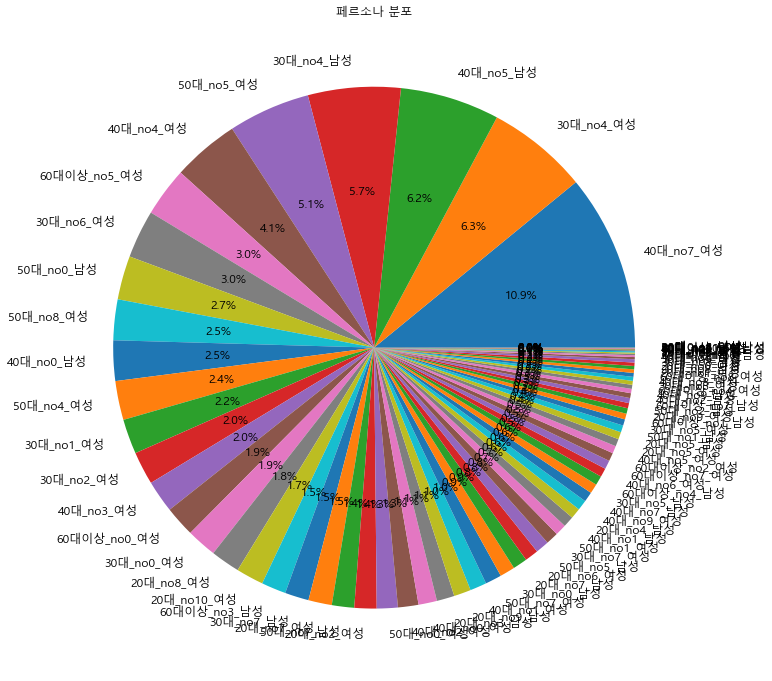

In [450]:
plt.figure(figsize = (14,12))
demo['persona'].value_counts().plot.pie(autopct = '%.1f%%', fontsize = 12)
plt.title('페르소나 분포')
plt.ylabel('')
plt.show()

___